German Traffic Sign Recognition Benchmark (GTSRB)
=================================================
---
Introduction au Deep Learning  (IDLE) - S. Aria, E. Maldonado, JL. Parouty - CNRS/SARI/DEVLOG - 2020

## Episode 1 : Preparation of data

 - Understanding the dataset
 - Preparing and formatting enhanced data
 - Save enhanced datasets


## 1/ Import and init

In [1]:
import os, time, sys
import csv
import math, random

import numpy as np
import matplotlib.pyplot as plt
import h5py

from skimage.morphology import disk
from skimage.filters import rank
from skimage import io, color, exposure, transform

import idle.pwk as ooo
from importlib import reload
reload(ooo)
ooo.init()

IDLE 2020 - Practical Work Module
  Version            : 0.1.1
  Run time           : Thursday 9 January 2020, 16:29:37
  Matplotlib style   : idle/talk.mplstyle
  TensorFlow version : 2.0.0
  Keras version      : 2.2.4-tf


## 2/ Read the dataset
Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
 - Each directory contains one CSV file with annotations ("GT-<ClassID>.csv") and the training images
 - First line is fieldnames: Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2;ClassId  
    
### 2.1/ Usefull functions

In [2]:
def read_dataset_dir(csv_filename):
    '''Reads traffic sign data from German Traffic Sign Recognition Benchmark dataset.

    Arguments:  csv filename
                Example /data/GTSRB/Train.csv
    Returns:   np array of images, np array of corresponding labels'''

    # ---- csv filename and path
    #
    name=os.path.basename(csv_filename)
    path=os.path.dirname(csv_filename)
    
    # ---- Read csv file
    #
    f,x,y = [],[],[]
    with open(csv_filename) as csv_file:
        reader = csv.DictReader(csv_file, delimiter=',')
        for row in reader:
            f.append( path+'/'+row['Path'] )
            y.append( int(row['ClassId'])  )
        csv_file.close()
    nb_images = len(f)

    # ---- Read images
    #
    for filename in f:
        image=io.imread(filename)
        x.append(image)
        ooo.update_progress(name,len(x),nb_images)

    # ---- Return
    return np.array(x),np.array(y)

### 2.2/ Read the data
We will read the following datasets:
 - **x_train, y_train** : Learning data
 - **x_test, y_test** : Validation or test data
 - x_meta, y_meta : Illustration data
 
The learning data will be randomly mixted and the illustration data sorted.

In [3]:
%%time

# ---- Read datasets
(x_train,y_train) = read_dataset_dir('./data/origine/Train.csv')
(x_test ,y_test)  = read_dataset_dir('./data/origine/Test.csv')
(x_meta ,y_meta)  = read_dataset_dir('./data/origine/Meta.csv')
    
# ---- Shuffle train set
combined = list(zip(x_train,y_train))
random.shuffle(combined)
x_train,y_train = zip(*combined)

# ---- Sort Meta
combined = list(zip(x_meta,y_meta))
combined.sort(key=lambda x: x[1])
x_meta,y_meta = zip(*combined)

Train.csv        [########################################] 100.0% of 39209
Test.csv         [########################################] 100.0% of 12630
Meta.csv         [########################################] 100.0% of 43
CPU times: user 5.44 s, sys: 17 s, total: 22.4 s
Wall time: 1min 7s


## 3/ Few statistics about train dataset
We want to know if our images are homogeneous in terms of size, ratio, width or height.

### 3.1/ Do statistics 

In [4]:
train_size  = []
train_ratio = []
train_lx    = []
train_ly    = []

test_size   = []
test_ratio  = []
test_lx     = []
test_ly     = []

for image in x_train:
    (lx,ly,lz) = image.shape
    train_size.append(lx*ly/1024)
    train_ratio.append(lx/ly)
    train_lx.append(lx)
    train_ly.append(ly)

for image in x_test:
    (lx,ly,lz) = image.shape
    test_size.append(lx*ly/1024)
    test_ratio.append(lx/ly)
    test_lx.append(lx)
    test_ly.append(ly)

### 3.2/ Show statistics

x_train size :  39209
y_train size :  39209
x_test size  :  12630
y_test size  :  12630


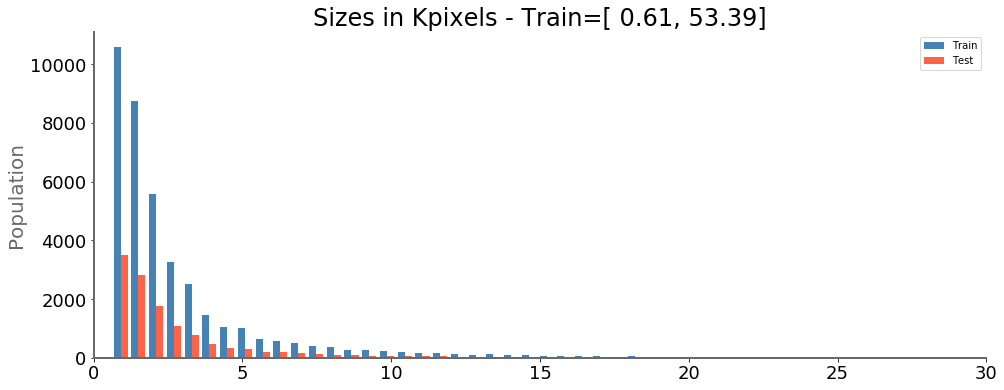

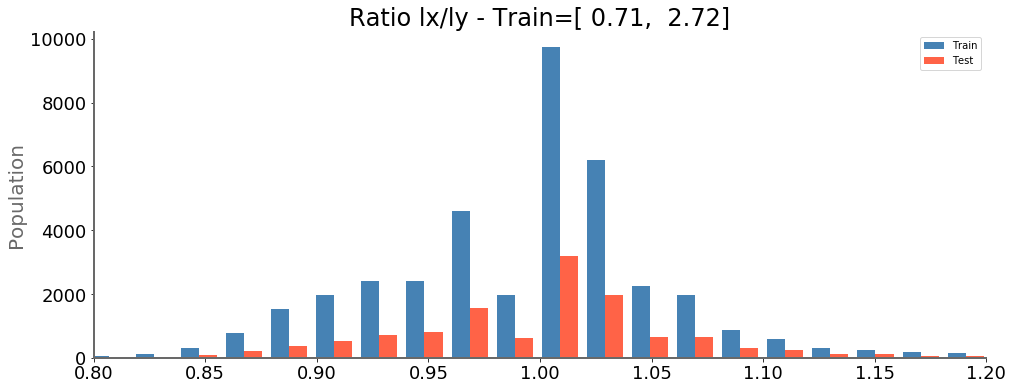

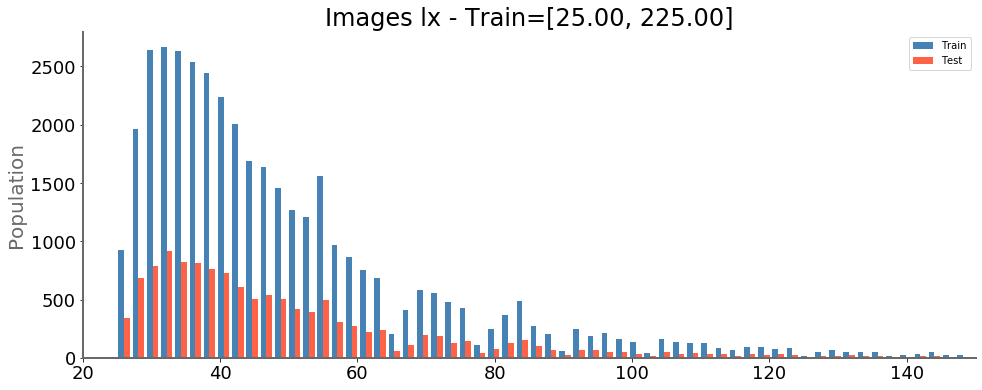

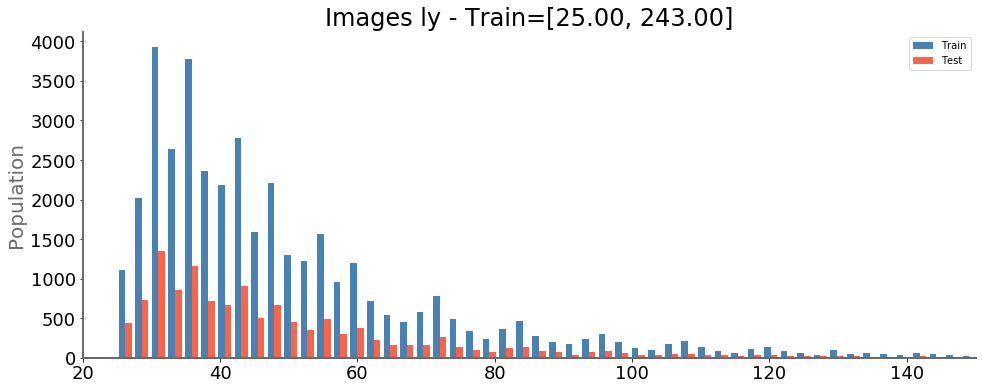

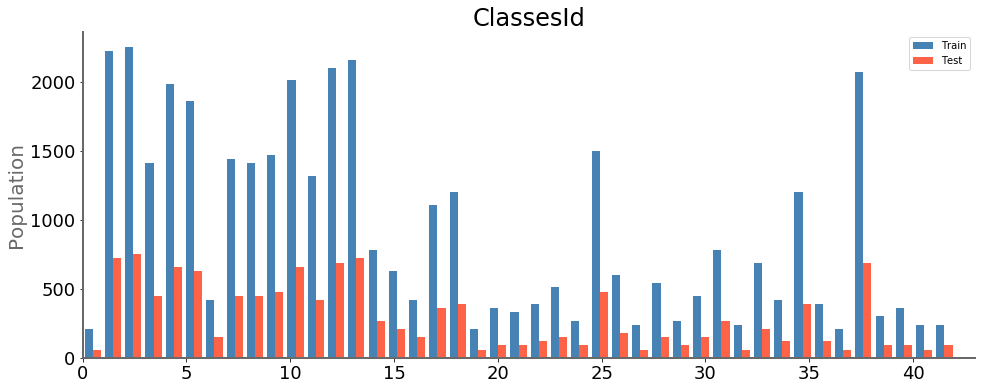

In [5]:
# ------ Global stuff
print("x_train size : ",len(x_train))
print("y_train size : ",len(y_train))
print("x_test size  : ",len(x_test))
print("y_test size  : ",len(y_test))

# ------ Statistics / sizes
plt.figure(figsize=(16,6))
plt.hist([train_size,test_size], bins=100)
plt.gca().set(title='Sizes in Kpixels - Train=[{:5.2f}, {:5.2f}]'.format(min(train_size),max(train_size)), 
              ylabel='Population',
              xlim=[0,30])
plt.legend(['Train','Test'])
plt.show()

# ------ Statistics / ratio lx/ly
plt.figure(figsize=(16,6))
plt.hist([train_ratio,test_ratio], bins=100)
plt.gca().set(title='Ratio lx/ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ratio),max(train_ratio)), 
              ylabel='Population',
              xlim=[0.8,1.2])
plt.legend(['Train','Test'])
plt.show()

# ------ Statistics / lx
plt.figure(figsize=(16,6))
plt.hist([train_lx,test_lx], bins=100)
plt.gca().set(title='Images lx - Train=[{:5.2f}, {:5.2f}]'.format(min(train_lx),max(train_lx)), 
              ylabel='Population',
              xlim=[20,150])
plt.legend(['Train','Test'])
plt.show()

# ------ Statistics / ly
plt.figure(figsize=(16,6))
plt.hist([train_ly,test_ly], bins=100)
plt.gca().set(title='Images ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ly),max(train_ly)), 
              ylabel='Population',
              xlim=[20,150])
plt.legend(['Train','Test'])
plt.show()

# ------ Statistics / classId
plt.figure(figsize=(16,6))
plt.hist([y_train,y_test], bins=43)
plt.gca().set(title='ClassesId', 
              ylabel='Population',
              xlim=[0,43])
plt.legend(['Train','Test'])
plt.show()

## 4/ List of classes
What are the 43 classes of our images...

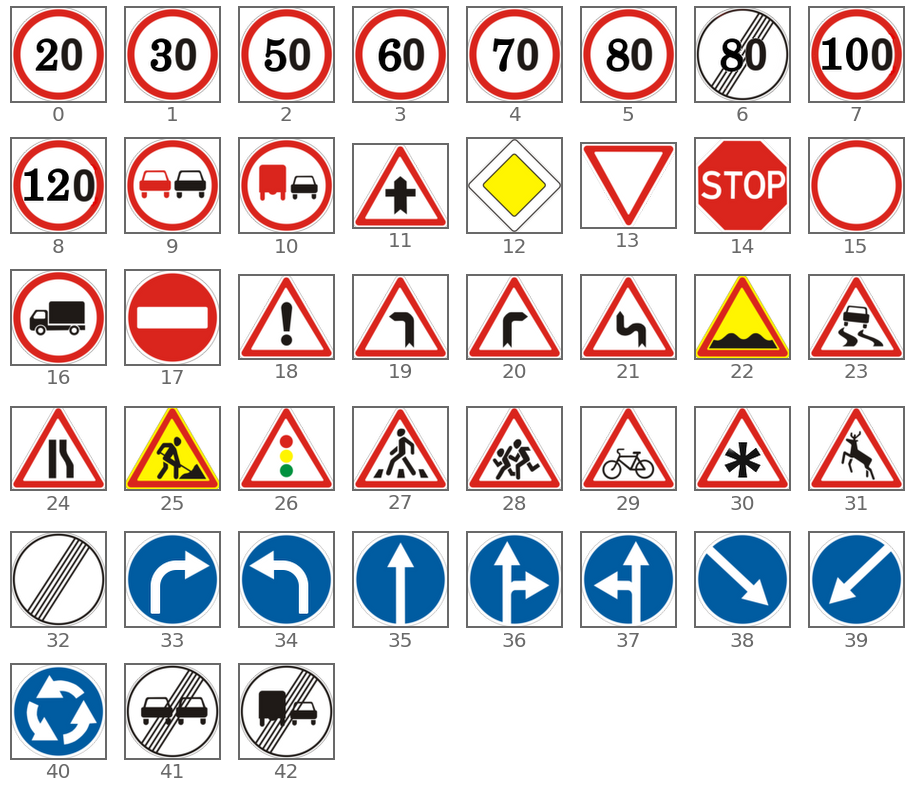

In [6]:
ooo.plot_images(x_meta,y_meta, range(43), columns=8, x_size=2, y_size=2, 
                                colorbar=False, y_pred=None, cm='binary')

## 5/ What does it really look like

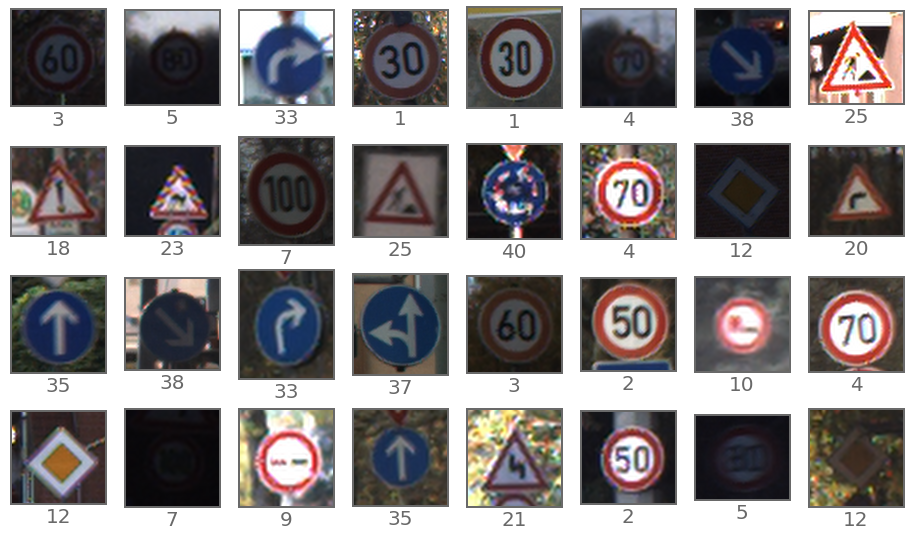

In [7]:
# ---- Get and show few images

samples = [ random.randint(0,len(x_train)-1) for i in range(32)]
ooo.plot_images(x_train,y_train, samples, columns=8, x_size=2, y_size=2, colorbar=False, y_pred=None, cm='binary')


## 6/ dataset cooking...

Images must have the **same size** to match the size of the network.   
It is possible to work on **rgb** or **monochrome** images and **equalize** the histograms.   
The data must be **normalized**.  

See : [Exposure with scikit-image](https://scikit-image.org/docs/dev/api/skimage.exposure.html)  
See : [Local histogram equalization](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#skimage.filters.rank.equalize)  
See : [Histogram equalization](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist)  

### 6.1/ Enhancement cook

In [8]:
def images_enhancement(images, width=25, height=25, mode='RGB'):
    '''
    Resize and convert images - doesn't change originals
    args:
        images :         images list
        width,height :   new images size (25,25)
        mode :           RGB | RGB-HE | L | L-HE | L-LHE | L-CLAHE
    return:
        numpy array of enhanced images
    '''
    modes = { 'RGB':3, 'RGB-HE':3, 'L':1, 'L-HE':1, 'L-LHE':1, 'L-CLAHE':1}
    lz=modes[mode]
    
    out=[]
    for image in images:
        
        # ---- Resize
        img = transform.resize(image, (width,height))

        # ---- RGB / Histogram Equalization
        if mode=='RGB-HE':
            hsv = color.rgb2hsv(img.reshape(width,height,3))
            hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
            img = color.hsv2rgb(hsv)
        
        # ---- Grayscale
        if mode=='L':
            img=color.rgb2gray(img)
            
        # ---- Grayscale / Histogram Equalization
        if mode=='L-HE':
            img=color.rgb2gray(img)
            img=exposure.equalize_hist(img)
            
        # ---- Grayscale / Local Histogram Equalization
        if mode=='L-LHE':
            img=color.rgb2gray(img)
            img=rank.equalize(img, disk(10))/255.
        
        # ---- Grayscale / Contrast Limited Adaptive Histogram Equalization (CLAHE)
        if mode=='L-CLAHE':
            img=color.rgb2gray(img)
            img=exposure.equalize_adapthist(img)
            
        # ---- Add image in list of list
        out.append(img)
        ooo.update_progress('Enhancement: ',len(out),len(images))

    # ---- Reshape images
    #     (-1, width,height,1) for L
    #     (-1, width,height,3) for RGB
    #
    out = np.array(out,dtype='float64')
    out = out.reshape(-1,width,height,lz)
    return out

### 6.2/ To get an idea of the different recipes

Enhancement:     [####################] 100.0% of 20
Enhancement:     [####################] 100.0% of 20
Enhancement:     [####################] 100.0% of 20
Enhancement:     [####################] 100.0% of 20
Enhancement:     [####################] 100.0% of 20
Enhancement:     [####################] 100.0% of 20

ORIGINE :



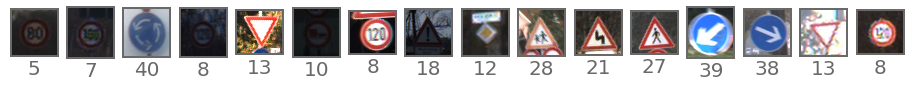


ENHANCED :

dataset : RGB  min,max=[0.012,1.000]  shape=(20, 25, 25, 3)


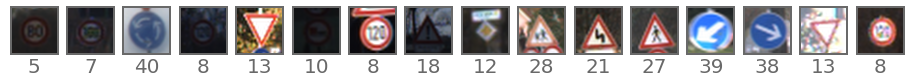

dataset : RGB-HE  min,max=[0.001,1.000]  shape=(20, 25, 25, 3)


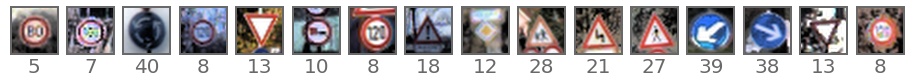

dataset : L  min,max=[0.029,1.000]  shape=(20, 25, 25, 1)


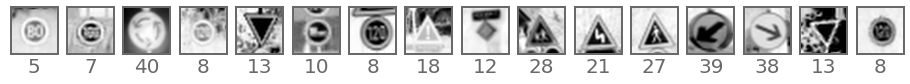

dataset : L-HE  min,max=[0.002,1.000]  shape=(20, 25, 25, 1)


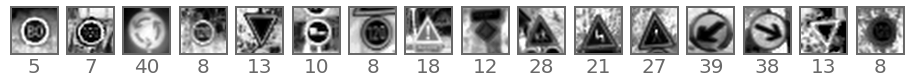

dataset : L-LHE  min,max=[0.000,1.000]  shape=(20, 25, 25, 1)


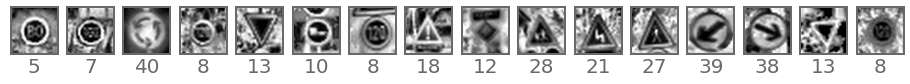

dataset : L-CLAHE  min,max=[0.000,1.000]  shape=(20, 25, 25, 1)


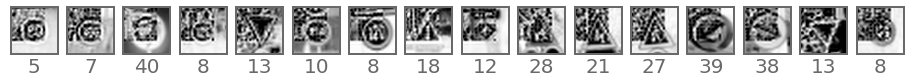

In [10]:
x_samples = x_train[:20]
y_samples = y_train[:20]

datasets  = {}

datasets['RGB']      = images_enhancement( x_samples, width=25, height=25, mode='RGB'  )
datasets['RGB-HE']   = images_enhancement( x_samples, width=25, height=25, mode='RGB-HE'  )
datasets['L']        = images_enhancement( x_samples, width=25, height=25, mode='L'  )
datasets['L-HE']     = images_enhancement( x_samples, width=25, height=25, mode='L-HE'  )
datasets['L-LHE']    = images_enhancement( x_samples, width=25, height=25, mode='L-LHE'  )
datasets['L-CLAHE']  = images_enhancement( x_samples, width=25, height=25, mode='L-CLAHE'  )

print('\nORIGINE :\n')
ooo.plot_images(x_train, y_train, range(16), columns=16, x_size=1, y_size=1, colorbar=False, y_pred=None, cm='binary')
print('\nENHANCED :\n')
for k,d in datasets.items():
    print("dataset : {}  min,max=[{:.3f},{:.3f}]  shape={}".format(k,d.min(),d.max(), d.shape))
    ooo.plot_images(d, y_train, range(16), columns=16, x_size=1, y_size=1, colorbar=False, y_pred=None, cm='binary')


### 6.3/ Cook and save
A function to save a dataset

In [15]:
def save_npy_dataset(x_train, y_train, x_test, y_test, dirname):
    
    # ---- create subdir in data
    path = './data/'+dirname
    os.makedirs(path, mode=0o750, exist_ok=True)
       
    # ---- save numpy dataset
    np.save(path+'/x_train.npy', x_train)
    np.save(path+'/y_train.npy', y_train)
    np.save(path+'/x_test.npy',  x_test)
    np.save(path+'/y_test.npy',  y_test)
    
    # ---- done
    size=ooo.get_directory_size(path)
    print('Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)\n'.format(path, str(x_train.shape),size))
    
    
def save_h5_dataset(x_train, y_train, x_test, y_test, h5name):
    
    # ---- Filename
    filename='./data/'+h5name
    
    # ---- Create h5 file
    with h5py.File(filename, "w") as f:
        f.create_dataset("x_train", data=x_train)
        f.create_dataset("y_train", data=y_train)
        f.create_dataset("x_test",  data=x_test)
        f.create_dataset("y_test",  data=y_test)
        
    # ---- done
    size=os.path.getsize(filename)/(1024*1024)
    print('Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)\n'.format(filename, str(x_train.shape),size))

Create enhanced datasets, and save them...

In [16]:
%%time

for s in [24, 48]:
    for m in ['RGB', 'RGB-HE', 'L', 'L-LHE']:
        # ---- A nice dataset name
        name='set-{}x{}-{}.h5'.format(s,s,m)
        print("\nDataset : ",name)
        # ---- Enhancement
        x_train_new = images_enhancement( x_train, width=s, height=s, mode=m )
        x_test_new  = images_enhancement( x_test,  width=s, height=s, mode=m )
        # ---- Save
        save_h5_dataset( x_train_new, y_train, x_test_new, y_test, name)

x_train_new,x_test_new=0,0



Dataset :  set-24x24-RGB.h5
Enhancement:     [########################################] 100.0% of 39209
Enhancement:     [########################################] 100.0% of 12630
Dataset : ./data/set-24x24-RGB.h5   shape : (39209, 24, 24, 3)     size :  683.8 Mo   (saved)


Dataset :  set-24x24-RGB-HE.h5
Enhancement:     [########################################] 100.0% of 39209
Enhancement:     [########################################] 100.0% of 12630
Dataset : ./data/set-24x24-RGB-HE.h5  shape : (39209, 24, 24, 3)     size :  683.8 Mo   (saved)


Dataset :  set-24x24-L.h5
Enhancement:     [########################################] 100.0% of 39209
Enhancement:     [########################################] 100.0% of 12630
Dataset : ./data/set-24x24-L.h5     shape : (39209, 24, 24, 1)     size :  228.2 Mo   (saved)


Dataset :  set-24x24-L-LHE.h5
Enhancement:     [########################################] 100.0% of 39209
Enhancement:     [########################################] 10

## 7/ Reload data to be sure ;-)

dataset loaded from h5 file.


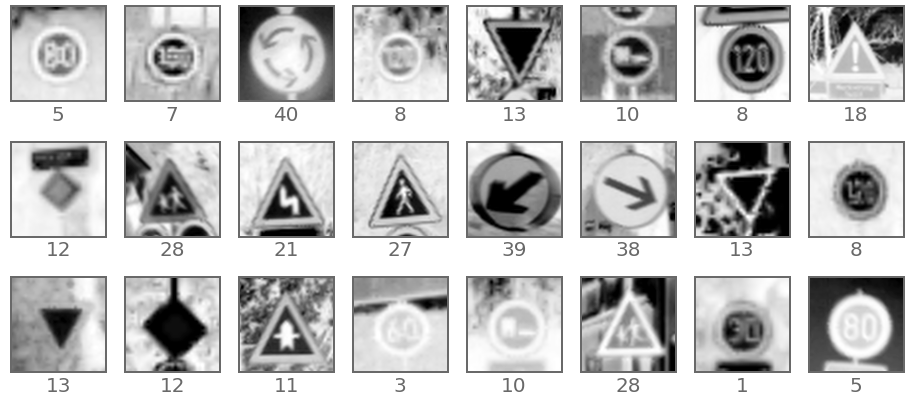

CPU times: user 641 ms, sys: 891 ms, total: 1.53 s
Wall time: 1.52 s


In [42]:
%%time

dataset='set-48x48-L'
samples=range(24)

with  h5py.File('./data/'+dataset+'.h5') as f:
    x_tmp = f['x_train'][:]
    y_tmp = f['y_train'][:]
    print("dataset loaded from h5 file.")

ooo.plot_images(x_tmp,y_tmp, samples, columns=8, x_size=2, y_size=2, colorbar=False, y_pred=None, cm='binary')
x_tmp,y_tmp=0,0

----
That's all folks !